In [1]:
using JuMP
using Plots
using LaTeXStrings
pyplot()
include("../src/OptimalConstraintTree.jl")
const OCT = OptimalConstraintTree

Main.OptimalConstraintTree

In [2]:
md = OCT.sagemark_to_ModelData(3, lse=false);
md.lbs[4] = -300.;
md.ubs[4] = 0;

In [3]:
n_samples = 1000;
X = OCT.sample(md, n_samples=n_samples);

In [4]:
ineq_trees, eq_trees = OCT.fit(md, X, lnr = OCT.base_otc());

Training trees...                  100%|████████████████| Time: 0:00:07

Refitting with best parameters...    0%|█               |  ETA: N/A
4m  Parameters:  cp=>0.1667

2mTraining trees...                    0%|█               |  ETA: N/A

2mTraining trees...                    2%|█               |  ETA: 0:00:07

2mTraining trees...                    4%|█               |  ETA: 0:00:08

2mTraining trees...                    6%|█               |  ETA: 0:00:08

2mTraining trees...                    8%|██              |  ETA: 0:00:07

2mTraining trees...                   10%|██              |  ETA: 0:00:07

2mTraining trees...                   12%|██              |  ETA: 0:00:07

2mTraining trees...                   14%|███             |  ETA: 0:00:06

2mTraining trees...                   16%|███             |  ETA: 0:00:06

2mTraining trees...                   18%|███             |  ETA: 0:00:06

2mTraining trees...                   20%|████            |  ETA: 0:00:06

2mTraining trees...                   22%|████            |  ETA: 0:00:06

2mTrain

Refitting with best parameters...    0%|█               |  ETA: N/A
4m  Parameters:  cp=>0.01923

2mTraining trees...                    0%|█               |  ETA: N/A



2mTraining trees...                    3%|█               |  ETA: 0:00:06

2mTraining trees...                    5%|█               |  ETA: 0:00:07

2mTraining trees...                    6%|█               |  ETA: 0:00:08

2mTraining trees...                    8%|██              |  ETA: 0:00:07

2mTraining trees...                   10%|██              |  ETA: 0:00:07

2mTraining trees...                   12%|██              |  ETA: 0:00:07

2mTraining trees...                   14%|███             |  ETA: 0:00:07

2mTraining trees...                   16%|███             |  ETA: 0:00:07

2mTraining trees...                   18%|███             |  ETA: 0:00:07

2mTraining trees...                   19%|████            |  ETA: 0:00:07

2mTraining trees...                   20%|████            |  ETA: 0:00:07

2mTraining trees...                   21%|████            |  ETA: 0:00:07

2mTraining trees...                   22%|████            |  ETA: 0:00:07

2mTraining trees...    

In [5]:
IAI.show_in_browser(ineq_trees[1].lnr)
IAI.show_in_browser(ineq_trees[2].lnr)

"C:\\Users\\Berk\\AppData\\Local\\Temp\\jl_7EC2.tmp.html"

In [6]:
# Getting data ready for plots
offset = [md.ineq_fns[2](X[j,:]) for j=1:n_samples];
# 1 - 0.01\frac{x_2}{x_3} - 0.01 x_2 - 0.005x_1x_3 \geq 0
feas_idxs = findall(x -> x.>=0, offset);
infeas_idxs = findall(x -> x.<0, offset);

In [7]:
include("../src/constraintify.jl");
upperDict, lowerDict = trust_region_data(ineq_trees[2].lnr, [Symbol("x",i) for i=1:4]);

In [8]:
lnr = ineq_trees[2].lnr;
n_nodes = IAI.get_num_nodes(lnr)
all_leaves = [i for i = 1:n_nodes if IAI.is_leaf(lnr, i)]
splits = [i for i=1:n_nodes if !(i in all_leaves)]
vks = [Symbol("x",i) for i=1:4];
fns = [];
# Calculation fn for x3
for i in splits
    threshold = IAI.get_split_threshold(lnr, i);
    weights = IAI.get_split_weights(lnr, i)[1];
    α = [];
    for j = 1:size(vks, 1)
        if vks[j] in keys(weights)
            append!(α, weights[vks[j]])
        else
            append!(α, 0.0)
        end
    end
    push!(fns, x -> (threshold - α[1]*x[1] - α[2]*x[2])/α[3]);
end

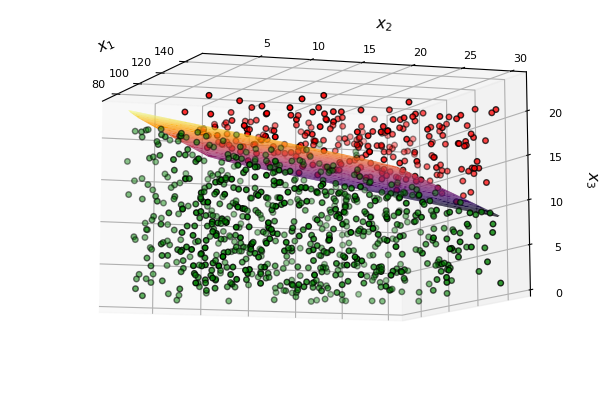

In [9]:
p_infeas = scatter(X[infeas_idxs,1], X[infeas_idxs,2], X[infeas_idxs,3], color=:red)
p_feas = scatter!(X[feas_idxs,1], X[feas_idxs,2], X[feas_idxs,3], color=:green)
s_1 = plot!(X[:,1], X[:,2], fns[1].([X[j,1:2] for j=1:n_samples]), st=:surface)
plot(s_1, xlabel=L"$x_1$", ylabel=L"$x_2$", zlabel=L"$x_3$", camera=(70,-10), legend=:none, colorbar=false)

In [10]:
# Actually solving the problem
m, x = OCT.jump_it(md);
OCT.add_linear_constraints!(m, x, md);
OCT.add_tree_constraints!(m, x, ineq_trees, eq_trees);
status = solve(m);
println("Solved minimum: ", sum(md.c .* getvalue(x)))
println("Known global bound: ", -147-2/3)
println("X values: ", getvalue(x))
println("Optimal X: ", vcat(exp.([5.01063529, 3.40119660, -0.48450710]), [-147-2/3]))

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 12 rows, 6 columns and 17 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+05]
Presolve removed 12 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Solution count 1: -149.762 
Pool objective bound -149.762

Optimal solution found (tolerance 1.00e-04)
Best objective -1.497622851128e+02, best bound -1.497622851128e+02, gap 0.0000%
Solved minimum: -149.7622851127601
Known global bound: -147.66666666666666
X values: [70.0, 30.000000000000007, 0.5, -149.7622851127601]
Optimal X: [149.9999993855616, 29.999976550144503, 0.6160007487168032, -147.66666666666666]
